In [ ]:
#### Introduction to Speech Processing

## What is a signal?

## What can we use speech signals for?

In [19]:
import pyaudio
import threading

class AudioManager:
    def __init__(self,chunk=128, fmt=pyaudio.paInt16, channels=1, rate=8000):
        self.chunk = chunk
        self.fmt = fmt
        self.channels = channels
        self.rate = rate
        self.energy_th = 0

    def build_silence_model(self, duration=1, factor=1.5):
        print("Please stay quiet. Measuring ambient noise...")
        frames = self.record(duration, filter_silence=False, wait_for_kb=False)
        es = []
        for f in frames:
            energy = self.energy(f)
            es.append(energy)
        es = np.array(es)
        self.energy_th = es.mean() + factor*es.std()

    def energy(self, frame):
        return sum([abs(v) for v in frame])/len(frame)
    
    def record(self, duration=1, filter_silence=True, wait_for_kb=True):
        if wait_for_kb:
            x = input("Press Enter to start recording...") # Python3
            #x = raw_input("Press Enter to start recording...") #Python2
        p = pyaudio.PyAudio()
        stream = p.open(format=self.fmt,
                        channels=self.channels,
                        rate=self.rate,
                        input=True,
                        frames_per_buffer=self.chunk)
        print("* recording")
        frames = []
        starting_silence = True
        silence_frame_cnt = 0
        for i in range(0, int((self.rate / self.chunk) * duration)):
            data = stream.read(self.chunk)
            d = np.fromstring(data, dtype=np.int16)
            if filter_silence:
                energy = self.energy(d)

                if energy < self.energy_th:
                    if starting_silence:
                        continue
                    else:
                        silence_frame_cnt += 1
                        if silence_frame_cnt == int(self.rate/self.chunk):
                            break
                else:
                    starting_silence = False
                    silence_frame_cnt = 0
            frames.append(d)
        print("* done recording")
        
        stream.stop_stream()
        stream.close()
        p.terminate()
        
        if filter_silence:
            print("before", len(frames))
            term = len(frames)
            for ii in range(len(frames)-1, -1, -1):
                e = self.energy(frames[ii])
                if e < self.energy_th:
                    term = ii
                else:
                    break
            frames = frames[:term]
            print("after", len(frames))
        return frames

    def play(self, frames):
        
        p = pyaudio.PyAudio()  
        #open stream
        stream = p.open(format = self.fmt,
                        channels = self.channels,
                        rate = self.rate,
                        output = True)
        
        if type(frames) is list:
            frames = list(frames)
            b = np.zeros(frames[0].shape, dtype=np.int16)
            frames.insert(0, b)
            frames.append(b)
            frames = np.concatenate(frames)
        
        stream.write(frames.tostring())
        
        #stop stream  
        stream.stop_stream()  
        stream.close()  
        #close PyAudio  
        p.terminate()  

def plot_fft(y, fs):

    n = len(y) # length of the signal
    k = np.arange(n)
    T = 2*n/float(fs)
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = fftpack.dct(y)
    Y = Y[:int(n/2)]
    plt.plot(frq, abs(Y))
    plt.show()

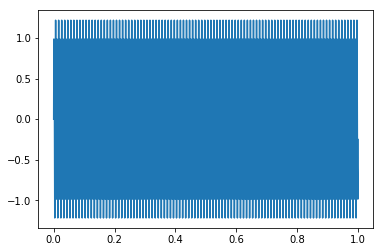

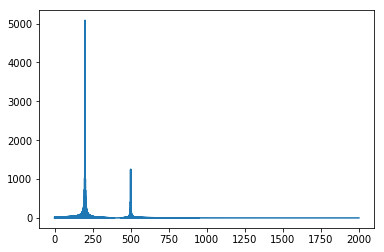

In [16]:
from scipy import signal, fftpack
import matplotlib.pyplot as plt
import numpy as np
import math

if __name__=="__main__":
    # Concept of normalized time and frequency...
    fs = 8000
    Ts = 1/float(fs)
    
    t = np.arange(0, 1, Ts)
    y = np.sin(2*np.pi*200*t) + 0.25*np.sin(2*np.pi*500*t)#+ np.tan(t + 0.5) + 2*np.cos(t + 0.5)
    plt.plot(t, y)
    plt.show()
    plot_fft(y, fs)


Please stay quiet. Measuring ambient noise...
* recording
* done recording
Press Enter to start recording...
* recording
* done recording


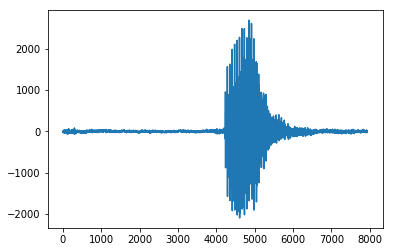

In [40]:
if __name__=="__main__":
    audioManager = AudioManager()
    audioManager.build_silence_model(factor=1.1)
    samples = audioManager.record(1, filter_silence=False)
    audioManager.play(samples)
    plt.plot(np.concatenate(samples))
    plt.show()

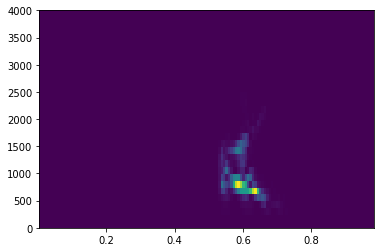

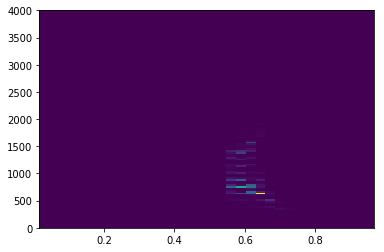

In [41]:
if __name__=="__main__":
    # Speech spectrogram
    f, t, Sxx = signal.spectrogram(np.concatenate(samples),
                                   fs=audioManager.rate,
                                   window=signal.gaussian(audioManager.chunk/2, audioManager.chunk/8),
                                   nperseg=audioManager.chunk/2)
    plt.pcolormesh(t, f, Sxx)
    plt.show()

    f, t, Sxx = signal.spectrogram(np.concatenate(samples),
                                   fs=audioManager.rate,
                                   window=signal.gaussian(audioManager.chunk*2, audioManager.chunk),
                                   nperseg=audioManager.chunk*2)
    plt.pcolormesh(t, f, Sxx)
    plt.show()

62
Voiced Region (Vowel)


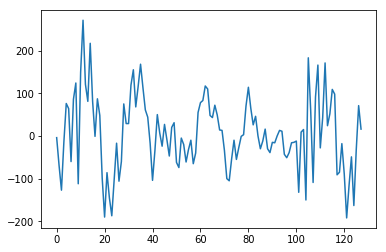

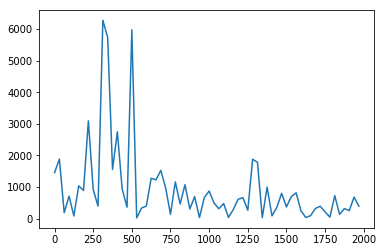

Noise


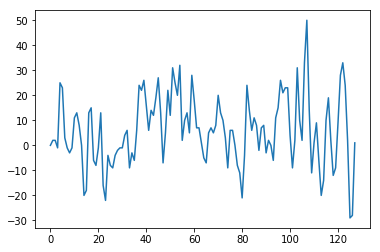

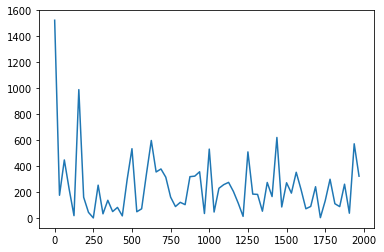

In [49]:
if __name__=="__main__":
    print(len(samples))
    print("Voiced Region (Vowel)")
    plt.plot(samples[45])
    plt.show()
    plot_fft(samples[45], fs=8000)
    print("Noise")
    plt.plot(samples[5])
    plt.show()
    plot_fft(samples[5], fs=8000)